# Landsat Data Acquisition - Quick Start: Single Image Download (LandsatMPC)

Simple example to download a Landsat 8/9 image from Microsoft Planetary Computer.

**Key Features:**
- 30m resolution optical imagery
- 16-day revisit time
- Historical archive back to 1972
- Thermal bands (Landsat 8/9)

Author: Peter Kongstad

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, configure_logging
from sat_data_acquisition.processing import save_geotiff
from sat_data_acquisition.config.settings import SatDataSettings

In [2]:
# Configure logging
configure_logging(verbose=False)

## Define Area of Interest

Create a bounding box around Copenhagen.

In [3]:
# Define area as bounding box (rectangular shape)
copenhagen_center = Point(12.5683, 55.6761)  # lon, lat
buffer = 0.024  # ~5 km

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area bounds: {geometry.bounds}")
print(f"Approximate area: {(buffer * 111 * 2)**2:.1f} km²")

Area bounds: (12.544300000000002, 55.6521, 12.5923, 55.7001)
Approximate area: 28.4 km²


## Download Image

Search for a recent Landsat image from Microsoft Planetary Computer with low cloud coverage.

In [7]:
# Initialize client
client = SatDataClient()
settings = SatDataSettings()

# Configure processing parameters
processing_params = ProcessingParams(
    satellite='LANDSATMPC',
    bands=['red', 'green', 'blue'],  # RGB bands for true color
    search_method='geometry',  # Landsat requires geometry search
    start_date='2024-06-01',
    end_date='2024-08-31',
    cloud_coverage=20,
    groupby='solar_day',
)

# Search and download
dataset = client.search_and_create_image(
    geometry=geometry,
    processing_params=processing_params,
)

print(f"Successfully downloaded {len(dataset.time)} image(s)")
print(f"Image shape: {dict(dataset.sizes)}")
print(f"Bands: {list(dataset.data_vars)}")
print(f"Date: {str(dataset.time.values[0])[:10]}")

INFO - Found 4 items for LANDSATMPC matching the search query.


Successfully downloaded 4 image(s)
Image shape: {'y': 182, 'x': 107, 'time': 4}
Bands: ['red', 'green', 'blue']
Date: 2024-06-20


## Visualize Image

Display the Landsat RGB composite with proper scaling.

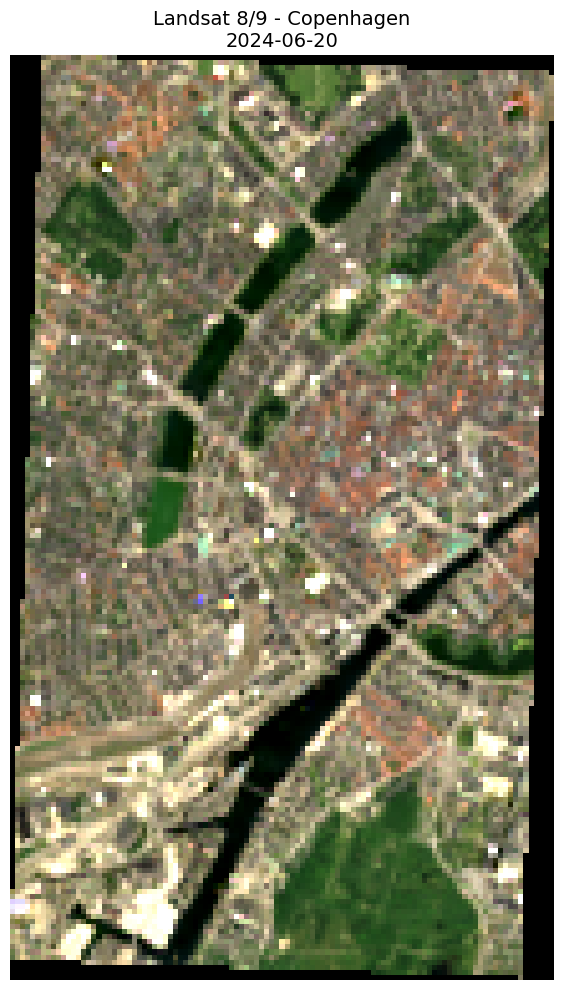

Image date: 2024-06-20
Resolution: 30m
CRS: PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DAT...


In [8]:
# Select first image
image = dataset.isel(time=0)

# Create RGB composite
rgb = np.dstack([
    image['red'].values,
    image['green'].values,
    image['blue'].values
])

# Landsat surface reflectance is scaled 0-65535, typical values 0-10000
# Use percentile stretching for better visualization
valid_pixels = rgb[rgb > 0]
if len(valid_pixels) > 0:
    p2, p98 = np.percentile(valid_pixels, [2, 98])
    rgb_stretched = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    rgb_display = np.power(rgb_stretched, 0.9)  # Slight gamma correction
else:
    rgb_display = np.zeros_like(rgb)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(rgb_display)
plt.title(f"Landsat 8/9 - Copenhagen\n{str(image.time.values)[:10]}", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Image date: {str(image.time.values)[:10]}")
print(f"Resolution: 30m")
print(f"CRS: {image.spatial_ref.attrs.get('crs_wkt', 'N/A')[:50]}...")

## Save to Disk (Optional)

Save the image as a GeoTIFF file.

In [ ]:
# Save image
date_str = str(dataset.time.values[0])[:10]

save_geotiff(
    image=dataset.sel(time=dataset.time.values[0]),
    identifier='copenhagen',
    datetime=date_str,
    satellite='LANDSATMPC',
    provider='MPC',
    output_path='./data/images',
    save_to_local=True,
    identifier_type='area_name',
    enable_compression=True,
    settings=settings,
)

print(f"✓ Saved: copenhagen_{date_str}.tif")

✓ Saved: copenhagen_2024-06-20.tif


: 